Вариант 6
Цель: Сравнение MaxPool и Global Average Pooling.

Спроектируйте сеть для входа (3, 64, 64) и выхода (32, 8, 8).
Условие: В сети обязательно должны быть и MaxPool2d, и AdaptiveAvgPool2d.
Эксперимент: Сравните выходы после MaxPool и GAP на одном и том же случайном тензоре, визуализируйте карты признаков и среднее значение активаций.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [11]:
class ConvNetPooling(nn.Module):
    def __init__(self):
        super().__init__()
        # Первый сверточный слой: 3 входных канала → 16 выходных
        self.layer1 = nn.Conv2d(3, 16, 3, padding=1)  # (16, 64, 64)
        
        # Второй сверточный слой: 16 входных каналов → 32 выходных
        self.layer2 = nn.Conv2d(16, 32, 3, padding=1)  # (32, 64, 64)
        
        # MaxPooling с размером ядра 8x8 и шагом 8
        self.maxpool = nn.MaxPool2d(8, stride=8)  # (32, 8, 8)
        
        # Adaptive Average Pooling до размера 8x8
        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(8)  # (32, 8, 8)
        
        # Global Average Pooling до размера 1x1
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # (32, 1, 1)
    
    def forward(self, x):
        # Пропускаем через первый сверточный слой + ReLU
        x = F.relu(self.layer1(x))  # (16, 64, 64)
        
        # Пропускаем через второй сверточный слой + ReLU
        x = F.relu(self.layer2(x))  # (32, 64, 64)
        
        # Возвращаем все три варианта пулинга для сравнения
        return self.maxpool(x), self.adaptive_avg_pool(x), self.global_avg_pool(x)

Создаем случайный тензор и инициализируем модель

In [12]:
x = torch.rand(1, 3, 64, 64) 

model = ConvNetPooling()

# Получаем выходы за один проход
maxpool_out, adaptive_avg_out, global_avg_out = model(x)

Подготавливаем данные для сравнения

In [13]:
outs = {
    'MaxPool (8x8)': maxpool_out[0].detach().numpy(),
    'AdaptiveAvgPool (8x8)': adaptive_avg_out[0].detach().numpy(),
    'GlobalAvgPool (1x1)': global_avg_out[0].detach().numpy()
}

1. Выводим средние значения активаций для каждого типа пулинга
2. Сравниваем:
    - Сравниваем только MaxPool и AdaptiveAvgPool (так как они оба 8x8)
    - GlobalAvgPool имеет другую размерность (1x1), поэтому сравнивается отдельно

In [15]:
print('СРАВНЕНИЕ ПУЛИНГОВ:')
print(f"Среднее значение MaxPool: {outs['MaxPool (8x8)'].mean():.4f}")
print(f"Среднее значение AdaptiveAvgPool: {outs['AdaptiveAvgPool (8x8)'].mean():.4f}")
print(f"Среднее значение GlobalAvgPool: {outs['GlobalAvgPool (1x1)'].mean():.4f}")
print()

# Сравнение MaxPool и AdaptiveAvgPool (оба 8x8)
diff = np.abs(outs['MaxPool (8x8)'] - outs['AdaptiveAvgPool (8x8)'])
print(f"Максимальная разница между MaxPool и AdaptiveAvgPool: {diff.max():.4f}")
print(f"Средняя разница между MaxPool и AdaptiveAvgPool: {diff.mean():.4f}")

СРАВНЕНИЕ ПУЛИНГОВ:
Среднее значение MaxPool: 0.1348
Среднее значение AdaptiveAvgPool: 0.0348
Среднее значение GlobalAvgPool: 0.0348

Максимальная разница между MaxPool и AdaptiveAvgPool: 0.2645
Средняя разница между MaxPool и AdaptiveAvgPool: 0.1000


Визуализируем карты признаков

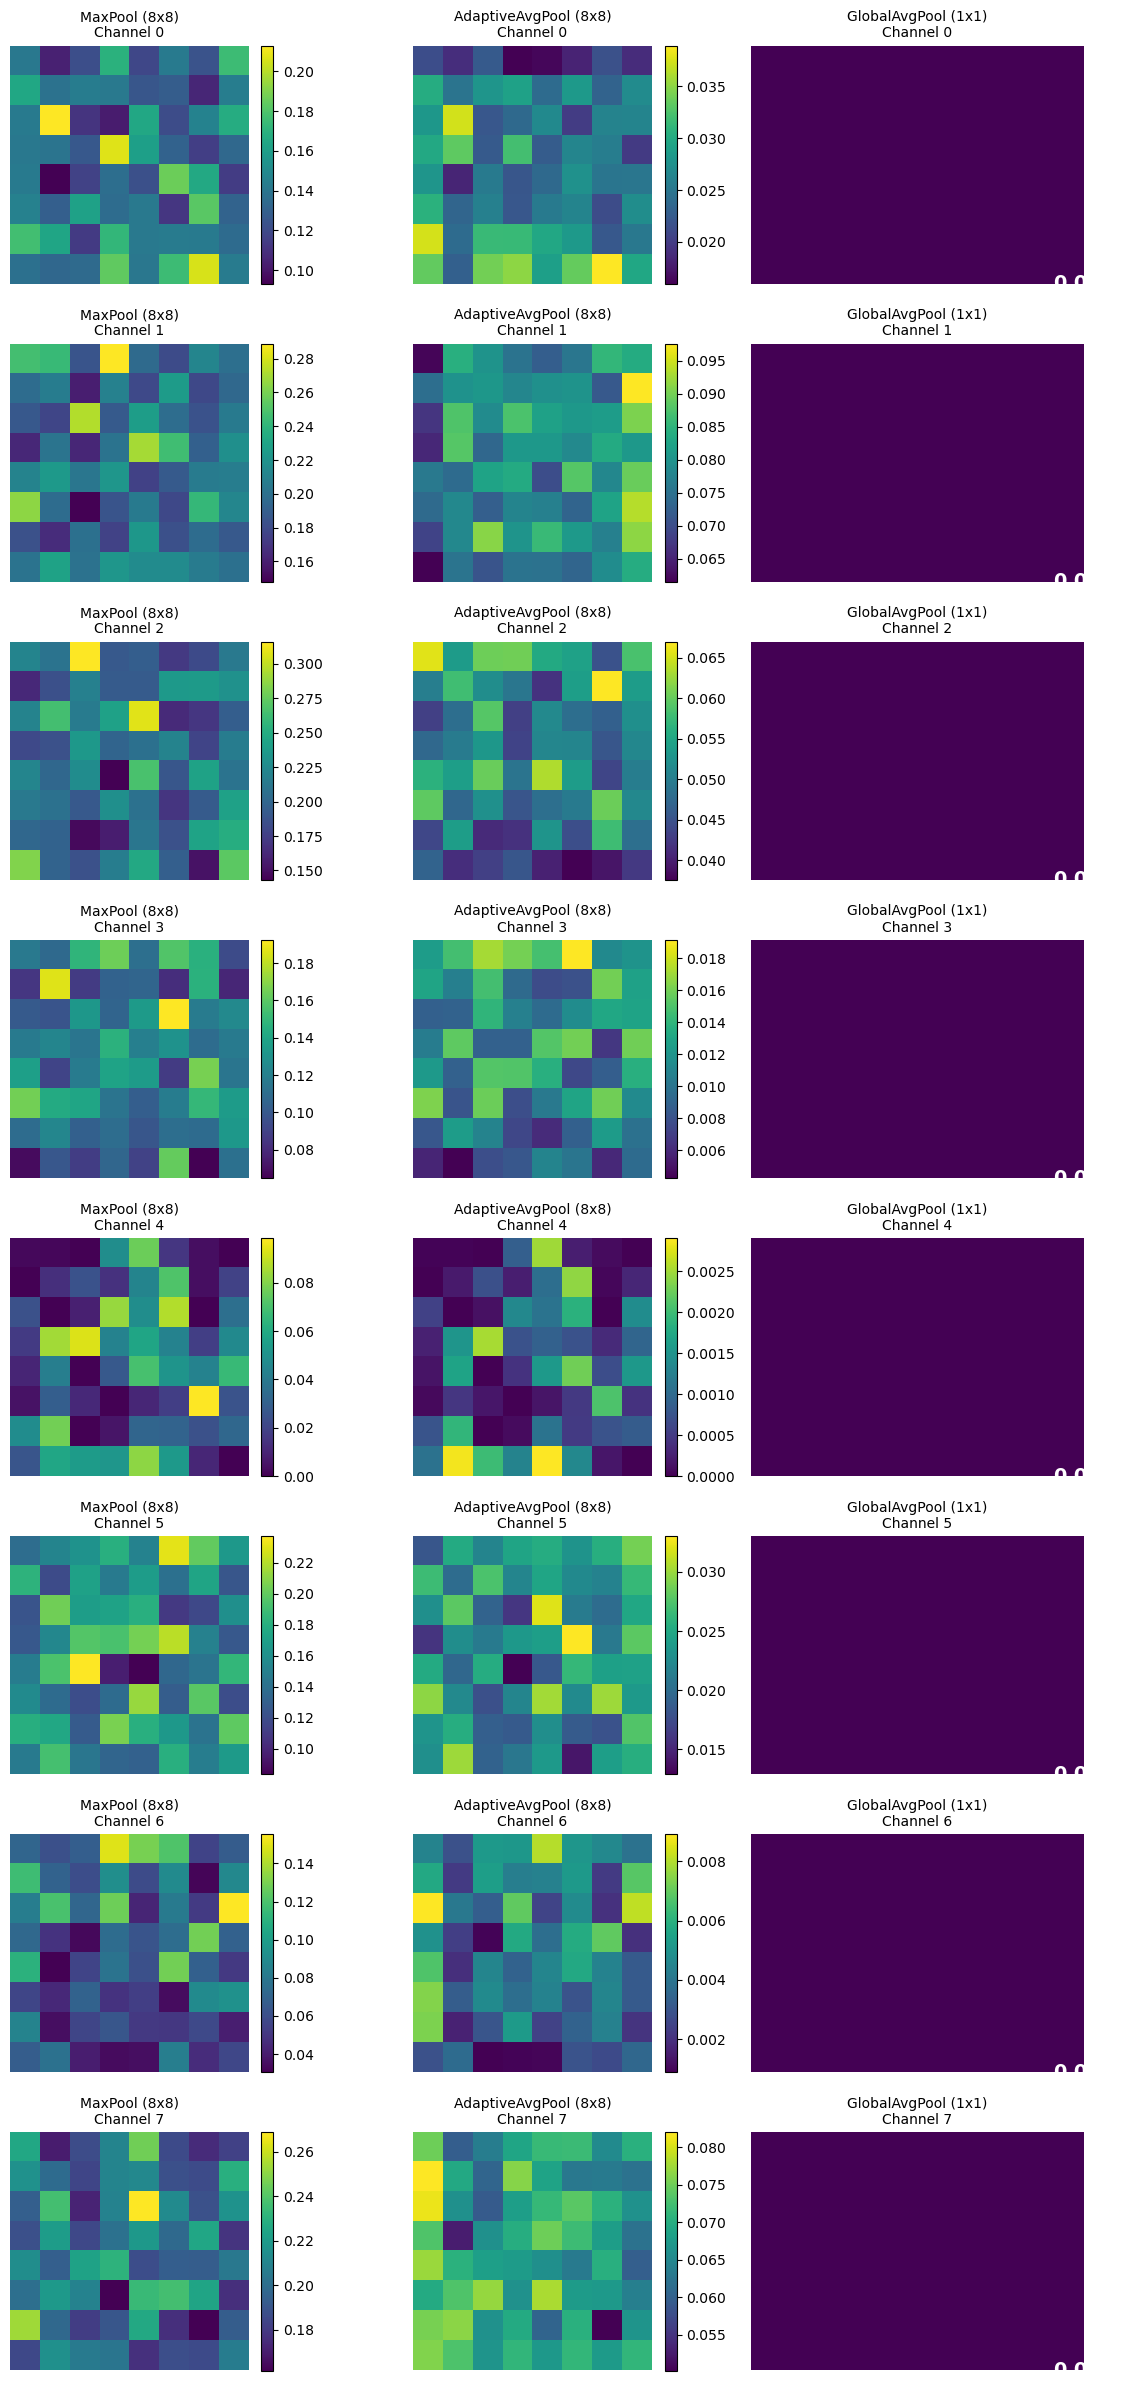

In [16]:
# Визуализация только первых 8 каналов для читаемости
num_channels_to_show = min(8, 32)

fig, axes = plt.subplots(num_channels_to_show, 3, figsize=(12, num_channels_to_show * 3))
titles = ['MaxPool (8x8)', 'AdaptiveAvgPool (8x8)', 'GlobalAvgPool (1x1)']

for i in range(num_channels_to_show):
    for j, (title, out_data) in enumerate(outs.items()):
        ax = axes[i, j] if num_channels_to_show > 1 else axes[j]
        
        if title == 'GlobalAvgPool (1x1)':
            # Для глобального пулинга показываем одно значение
            ax.imshow(out_data[i:i+1], cmap='viridis', aspect='auto')
            ax.text(0.5, 0.5, f'{out_data[i][0][0]:.3f}', 
                   ha='center', va='center', 
                   color='white', fontsize=14, fontweight='bold')
            ax.set_title(f'{title}\nChannel {i}', fontsize=10)
        else:
            # Для 8x8 пулингов
            im = ax.imshow(out_data[i], cmap='viridis')
            ax.set_title(f'{title}\nChannel {i}', fontsize=10)
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

Визуализируем распределение активаций

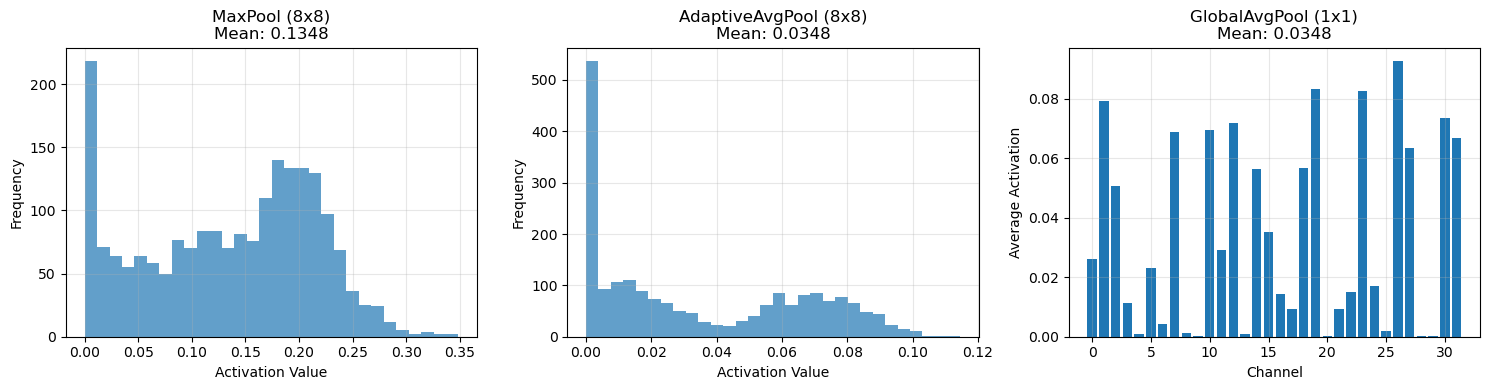

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (title, out_data) in enumerate(outs.items()):
    if title == 'GlobalAvgPool (1x1)':
        # Для глобального пулинга - гистограмма средних по каналам
        channel_means = out_data.reshape(32, -1).mean(axis=1)
        axes[idx].bar(range(32), channel_means)
        axes[idx].set_xlabel('Channel')
        axes[idx].set_ylabel('Average Activation')
    else:
        # Для 8x8 пулингов - гистограмма всех значений
        flat_data = out_data.flatten()
        axes[idx].hist(flat_data, bins=30, alpha=0.7)
        axes[idx].set_xlabel('Activation Value')
        axes[idx].set_ylabel('Frequency')
    
    axes[idx].set_title(f'{title}\nMean: {out_data.mean():.4f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()